#### This jupyter can evaluate the performance of each method with 10-X cross-validation.

In [17]:
import copy
import multiprocessing
import os
import pickle
import sys
import time
import time as tm
import warnings
from functools import partial
from os.path import join

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats
import scipy.stats as st
import seaborn as sns
import tangram as tg
from IPython.display import display
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wasserstein_distance
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

In [18]:
def SpaGE_impute(K):
    print("We run SpaGE for this data\n")
    sys.path.append("Extenrnal/SpaGE-master/")
    from SpaGE.main import SpaGE

    global RNA_data, Spatial_data, train_gene, predict_gene
    RNA_data = RNA_data.loc[(RNA_data.sum(axis=1) != 0)]
    RNA_data = RNA_data.loc[(RNA_data.var(axis=1) != 0)]
    train = np.array(train_gene[K])
    predict = np.array(predict_gene[K])
    pv = len(train) / 2
    Spatial = Spatial_data[train]
    Img_Genes = SpaGE(Spatial, RNA_data.T, n_pv=int(pv), genes_to_predict=predict)
    result = Img_Genes[predict]
    return result


def gimVI_impute(K):
    print("We run gimVI for this data\n")
    import scanpy as sc
    import scvi
    import torch
    from scvi.external import GIMVI
    from torch.nn.functional import cosine_similarity, sigmoid, softmax

    global RNA_data_adata, Spatial_data_adata, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    Genes = list(Spatial_data_adata.var_names)
    rand_gene_idx = [Genes.index(x) for x in test_list]
    n_genes = len(Genes)
    rand_train_gene_idx = sorted(set(range(n_genes)) - set(rand_gene_idx))
    rand_train_genes = np.array(Genes)[rand_train_gene_idx]
    rand_genes = np.array(Genes)[rand_gene_idx]
    spatial_data_partial = Spatial_data_adata[:, rand_train_genes]
    sc.pp.filter_cells(spatial_data_partial, min_counts=0)
    seq_data = copy.deepcopy(RNA_data_adata)
    seq_data = seq_data[:, Genes]
    sc.pp.filter_cells(seq_data, min_counts=0)
    scvi.external.GIMVI.setup_anndata(spatial_data_partial)
    scvi.external.GIMVI.setup_anndata(seq_data)
    model = GIMVI(seq_data, spatial_data_partial)
    model.train(200)
    _, imputation = model.get_imputed_values(normalized=False)
    imputed = imputation[:, rand_gene_idx]
    result = pd.DataFrame(imputed, columns=rand_genes)
    print(test_list == rand_genes)
    print(train_list == rand_train_genes)
    return result


def novoSpaRc_impute(K):
    print("We run novoSpaRc for this data\n")
    import novosparc as nc

    global RNA_data, Spatial_data, locations, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    gene_names = np.array(RNA_data.index.values)
    dge = RNA_data.values
    dge = dge.T
    num_cells = dge.shape[0]
    print("number of cells and genes in the matrix:", dge.shape)

    hvg = np.argsort(np.divide(np.var(dge, axis=0), np.mean(dge, axis=0) + 0.0001))
    dge_hvg = dge[:, hvg[-2000:]]

    num_locations = locations.shape[0]

    p_location, p_expression = nc.rc.create_space_distributions(
        num_locations, num_cells
    )
    cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(
        dge_hvg, locations, num_neighbors_source=5, num_neighbors_target=5
    )

    insitu_matrix = np.array(Spatial_data[train_list])
    insitu_genes = np.array(Spatial_data[train_list].columns)
    test_genes = np.array(test_list)
    test_matrix = np.array(Spatial_data[test_list])

    markers_in_sc = np.array([], dtype="int")
    for marker in insitu_genes:
        marker_index = np.where(gene_names == marker)[0]
        if len(marker_index) > 0:
            markers_in_sc = np.append(markers_in_sc, marker_index[0])
    cost_marker_genes = cdist(
        dge[:, markers_in_sc] / np.amax(dge[:, markers_in_sc]),
        insitu_matrix / np.amax(insitu_matrix),
    )
    alpha_linear = 0.5
    gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(
        cost_marker_genes,
        cost_expression,
        cost_locations,
        alpha_linear,
        p_expression,
        p_location,
        "square_loss",
        epsilon=5e-3,
        verbose=True,
    )
    sdge = np.dot(dge.T, gw)
    imputed = pd.DataFrame(sdge, index=RNA_data.index)
    result = imputed.loc[test_genes]
    result = result.T
    return result


def SpaOTsc_impute(K):
    print("We run SpaOTsc for this data\n")
    sys.path.append("Extenrnal/SpaOTsc/")
    from spaotsc import SpaOTsc

    global RNA_data, Spatial_data, locations, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    df_sc = RNA_data.T
    df_IS = Spatial_data
    pts = locations
    is_dmat = distance_matrix(pts, pts)
    df_is = df_IS.loc[:, train_list]

    gene_is = df_is.columns.tolist()
    gene_sc = df_sc.columns.tolist()
    gene_overloap = list(set(gene_is).intersection(gene_sc))
    a = df_is[gene_overloap]
    b = df_sc[gene_overloap]

    rho, pval = stats.spearmanr(a, b, axis=1)
    rho[np.isnan(rho)] = 0
    mcc = rho[-(len(df_sc)) :, 0 : len(df_is)]
    C = np.exp(1 - mcc)
    issc = SpaOTsc.spatial_sc(sc_data=df_sc, is_data=df_is, is_dmat=is_dmat)
    issc.transport_plan(
        C**2, alpha=0, rho=1.0, epsilon=0.1, cor_matrix=mcc, scaling=False
    )
    gamma = issc.gamma_mapping
    for j in range(gamma.shape[1]):
        gamma[:, j] = gamma[:, j] / np.sum(gamma[:, j])
    X_pred = np.matmul(gamma.T, np.array(issc.sc_data.values))
    result = pd.DataFrame(data=X_pred, columns=issc.sc_data.columns.values)
    test_genes = test_list
    result = result.loc[:, test_genes]
    return result


def stPlus_impute(K):
    global RNA_data, Spatial_data, outdir, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    save_path_prefix = join(outdir, "process_file/stPlus-demo")
    if not os.path.exists(join(outdir, "process_file")):
        os.mkdir(join(outdir, "process_file"))
    stPlus_res = stPlus(
        Spatial_data[train_list], RNA_data.T, test_list, save_path_prefix
    )
    return stPlus_res


def Tangram_impute(K, annotate=None, modes="clusters", density="rna_count_based"):
    import tangram as tg
    import torch
    from torch.nn.functional import cosine_similarity, sigmoid, softmax

    print("We run Tangram for this \n" + DataDir)
    global RNA_data_adata, Spatial_data_adata, locations, train_gene, predict_gene
    test_list = predict_gene[K]
    test_list = [x.lower() for x in test_list]
    train_list = train_gene[K]
    spatial_data_partial = Spatial_data_adata[:, train_list]
    train_list = np.array(train_list)
    if annotate == None:
        RNA_data_adata_label = RNA_data_adata
        sc.pp.normalize_total(RNA_data_adata_label)
        sc.pp.log1p(RNA_data_adata_label)
        sc.pp.highly_variable_genes(RNA_data_adata_label)
        RNA_data_adata_label = RNA_data_adata_label[
            :, RNA_data_adata_label.var.highly_variable
        ]
        sc.pp.scale(RNA_data_adata_label, max_value=10)
        sc.tl.pca(RNA_data_adata_label)
        sc.pp.neighbors(RNA_data_adata_label)
        sc.tl.leiden(RNA_data_adata_label, resolution=0.5)
        RNA_data_adata.obs["leiden"] = RNA_data_adata_label.obs.leiden
    else:
        global CellTypeAnnotate
        RNA_data_adata.obs["leiden"] = CellTypeAnnotate
    tg.pp_adatas(RNA_data_adata, spatial_data_partial, genes=train_list)
    device = torch.device("cuda:0")
    if modes == "clusters":
        ad_map = tg.map_cells_to_space(
            RNA_data_adata,
            spatial_data_partial,
            device=device,
            mode=modes,
            cluster_label="leiden",
            density_prior=density,
        )
        ad_ge = tg.project_genes(ad_map, RNA_data_adata, cluster_label="leiden")
    else:
        ad_map = tg.map_cells_to_space(
            RNA_data_adata, spatial_data_partial, device=device
        )
        ad_ge = tg.project_genes(ad_map, RNA_data_adata)
    test_list = list(set(ad_ge.var_names) & set(test_list))
    test_list = np.array(test_list)
    pre_gene = pd.DataFrame(
        ad_ge[:, test_list].X,
        index=ad_ge[:, test_list].obs_names,
        columns=ad_ge[:, test_list].var_names,
    )
    return pre_gene

# Data Input

In [19]:
"""
This function integrates two single-cell datasets, spatial and scRNA-seq, 
and predictes the expression of the spatially unmeasured genes from the scRNA-seq data.

Parameters
-------
RNA_file : str
    scRNA-seq data count file with Tab-delimited (cells X genes).
Spatial_file : str
    spatial count data file with Tab-delimited, please note that the file has no index.
location_file : str
    spatial spot coordinate file name with Tab-delimited, please note that the file has no index.
device : str
    Option,  ['CPU','GPU'], defaults to 'CPU'
train_gene : list
    genes for integrations, you can support more than one train list.
predict_gene : list
    genes for prediction, you can support more than one test list.
outdir : str
    result file stored direction    
"""

DataDir = "../DataPreparation/newData/"
outdir = "XeniumResults/"
RNA_file = DataDir + "scRNA_count.txt"
Spatial_file = DataDir + "Insitu_count.txt"
location_file = DataDir + "Locations.txt"

RNA_data = pd.read_table(RNA_file, header=0, index_col=0)
Spatial_data = pd.read_table(Spatial_file, sep="\t", header=0)
RNA_data_adata = sc.read(RNA_file, sep="\t", first_column_names=True).T
Spatial_data_adata = sc.read(Spatial_file, sep="\t")
locations = np.loadtxt(location_file, skiprows=1)

train_gene = np.load(DataDir + "train_list.npy", allow_pickle=True).tolist()
predict_gene = np.load(DataDir + "test_list.npy", allow_pickle=True).tolist()

device = "GPU"
if not os.path.exists(outdir):
    os.mkdir(outdir)

#### Predicting undetected transcripts by each method

In [20]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(2) as pool:
    result = pd.concat(pool.map(SpaGE_impute, KFOLD), axis=1)
result.to_csv(outdir + "/SpaGE_impute.csv", header=1, index=1)

We run SpaGE for this data
We run SpaGE for this data


We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data

We run SpaGE for this data



In [21]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(2) as pool:
    result = pd.concat(pool.map(SpaOTsc_impute, KFOLD), axis=1)
result.to_csv(outdir + "/SpaOTsc_impute.csv", header=1, index=1)

We run SpaOTsc for this data
We run SpaOTsc for this data


We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data

We run SpaOTsc for this data



In [22]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(2) as pool:
    result = pd.concat(pool.map(novoSpaRc_impute, KFOLD), axis=1)
result.to_csv(outdir + "/novoSpaRc_impute.csv", header=1, index=1)

We run novoSpaRc for this data
We run novoSpaRc for this data


number of cells and genes in the matrix:number of cells and genes in the matrix:  (13785, 26474)(13785, 26474)

Setting up for reconstruction ... Setting up for reconstruction ... done ( 52.65 seconds )
done ( 52.78 seconds )
It.  |Err         
-------------------
    0|1.017122e-04|It.  |Err         
-------------------

    0|1.055147e-04|
We run novoSpaRc for this data

number of cells and genes in the matrix: (13785, 26474)
We run novoSpaRc for this data

number of cells and genes in the matrix: (13785, 26474)
Setting up for reconstruction ... Setting up for reconstruction ... done ( 50.01 seconds )
done ( 50.09 seconds )
It.  |Err         
-------------------
    0|1.118467e-04|
It.  |Err         
-------------------
    0|9.479886e-05|
We run novoSpaRc for this data

number of cells and genes in the matrix: (13785, 26474)
Setting up for reconstruction ... We run novoSpaRc for this data

number of cells and genes in t

# GPU Platform gimVI, Tangram, and stPlus

In [23]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(2) as pool:
    result = pd.concat(pool.map(gimVI_impute, KFOLD), axis=1)
result.to_csv(outdir + "/gimVI_impute.csv", header=1, index=1)

KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(2) as pool:
    result = pd.concat(pool.map(Tangram_impute, KFOLD), axis=1)
result.to_csv(outdir + "/Tangram_impute.csv", header=1, index=1)

We run gimVI for this data
We run gimVI for this data




Global seed set to 0
Global seed set to 0
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should se

Epoch 200/200: 100%|██████████| 200/200 [06:06<00:00,  1.80s/it, loss=103, v_num=1] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:06<00:00,  1.79s/it, loss=103, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:06<00:00,  1.83s/it, loss=103, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32

Epoch 200/200: 100%|██████████| 200/200 [06:03<00:00,  1.83s/it, loss=101, v_num=1]]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:03<00:00,  1.79s/it, loss=99.6, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:03<00:00,  1.82s/it, loss=99.6, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False 

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32

Epoch 200/200: 100%|██████████| 200/200 [06:07<00:00,  1.82s/it, loss=102, v_num=1] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:07<00:00,  1.81s/it, loss=103, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:07<00:00,  1.84s/it, loss=103, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32

Epoch 200/200: 100%|██████████| 200/200 [06:13<00:00,  1.81s/it, loss=101, v_num=1] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:13<00:00,  1.87s/it, loss=101, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:14<00:00,  1.78s/it, loss=102, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:14<00:00,  1.87s/it, loss=102, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:08<00:00,  1.54s/it, loss=103, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fa

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [04:56<00:00,  1.46s/it, loss=101, v_num=1] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:56<00:00,  1.48s/it, loss=101, v_num=1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fa

INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe li

Score: 0.324, KL reg: 0.260
Score: 0.322, KL reg: 0.256
Score: 0.673, KL reg: 0.001
Score: 0.668, KL reg: 0.001
Score: 0.676, KL reg: 0.001
Score: 0.671, KL reg: 0.001
Score: 0.671, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.672, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Saving results..


We run Tangram for this 
../DataPreparation/newData/
We run Tangram for this 
../DataPreparation/newData/


INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training w

Score: 0.320, KL reg: 0.256Score: 0.324, KL reg: 0.258

Score: 0.658, KL reg: 0.001
Score: 0.660, KL reg: 0.001
Score: 0.660, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.664, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.664, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.664, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.664, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.664, KL reg: 0.001
Score: 0.662, KL reg: 0.001
Score: 0.664, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Saving results..


We run Tangram for this 
../DataPreparation/newData/
We run Tangram for this 
../DataPreparation/newData/


INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 223 genes and rna_count_based densit

Score: 0.326, KL reg: 0.281


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 223 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.320, KL reg: 0.279
Score: 0.673, KL reg: 0.001
Score: 0.657, KL reg: 0.001
Score: 0.676, KL reg: 0.001
Score: 0.660, KL reg: 0.001
Score: 0.676, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001
Score: 0.677, KL reg: 0.001
Score: 0.661, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Saving results..


We run Tangram for this 
../DataPreparation/newData/
We run Tangram for this 
../DataPreparation/newData/


INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 223 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.325, KL reg: 0.278


INFO:root:223 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:223 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 223 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.322, KL reg: 0.278
Score: 0.659, KL reg: 0.001
Score: 0.650, KL reg: 0.001Score: 0.662, KL reg: 0.001

Score: 0.663, KL reg: 0.001
Score: 0.653, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.654, KL reg: 0.001
Score: 0.654, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.654, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.655, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.655, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.655, KL reg: 0.001
Score: 0.663, KL reg: 0.001
Score: 0.655, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Saving results..


We run Tangram for this 
../DataPreparation/newData/


INFO:root:224 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:224 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 224 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.319, KL reg: 0.283
Score: 0.654, KL reg: 0.001
Score: 0.657, KL reg: 0.001
Score: 0.657, KL reg: 0.001
Score: 0.658, KL reg: 0.001
Score: 0.658, KL reg: 0.001
Score: 0.658, KL reg: 0.001
Score: 0.658, KL reg: 0.001
Score: 0.658, KL reg: 0.001
Score: 0.658, KL reg: 0.001


INFO:root:Saving results..


We run Tangram for this 
../DataPreparation/newData/


INFO:root:224 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:224 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 224 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.317, KL reg: 0.275
Score: 0.641, KL reg: 0.001
Score: 0.643, KL reg: 0.001
Score: 0.644, KL reg: 0.001
Score: 0.644, KL reg: 0.001
Score: 0.644, KL reg: 0.001
Score: 0.645, KL reg: 0.001
Score: 0.645, KL reg: 0.001
Score: 0.645, KL reg: 0.001
Score: 0.645, KL reg: 0.001


INFO:root:Saving results..


# Seurat impute file process

In [24]:
input_path = "../DataPreparation/newData/"
output_path = "XeniumResults/"
os.system("Rscript RCodes/Seurat.r " + input_path + " " + output_path)

Read 248 items
Warning message:
In dir.create(Args[7]) : 'XeniumResults' already exists


[1] "We Used Test Genes : "
 [1] "Cobll1"   "Opalin"   "Cd68"     "Sema3a"   "Cacna2d2" "Cntnap4" 
 [7] "Spag16"   "Kcnmb2"   "Tanc1"    "Bhlhe22"  "Rspo1"    "Pip5k1b" 
[13] "Acvrl1"   "Acta2"    "Bcl11b"   "Htr1f"    "Cd44"     "Trem2"   
[19] "Tmem132d" "Opn3"     "Slc13a4"  "Nrn1"     "Deptor"   "Pde11a"  
[25] "Btbd11"  
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4690 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Fezf2"         "Adgrl4"        "Cdh20"         "Cntn6"        
 [5] "Kcnh5"         "Siglech"       "Pglyrp1"       "Epha4"        
 [9] "Nell1"         "Kctd12"        "Gad2"          "Prox1"        
[13] "Hpcal1"        "Cort"          "2010300C02Rik" "Dner"         
[17] "Fos"           "Gad1"          "Nts"           "Garnl3"       
[21] "Slit2"         "Rasgrf2"       "Igfbp4"        "Lyz2"         
[25] "Myl4"         
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4685 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Sox11"   "Sipa1l3" "Sla"     "Vat1l"   "Vip"     "Cd24a"   "Mapk4"  
 [8] "Foxp2"   "Pdzrn3"  "Kctd8"   "Slc44a5" "Tmem163" "Trp73"   "Gm19410"
[15] "Pecam1"  "Aldh1a2" "Sema5b"  "Tox"     "Nostrin" "Cplx3"   "Arc"    
[22] "Chodl"   "Gfra2"   "Spi1"    "Pln"    
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4894 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Npy2r"   "Col6a1"  "Meis2"   "Hapln1"  "Rims3"   "Rorb"    "Pkib"   
 [8] "Cpne8"   "Rasl10a" "Trpc4"   "Trbc2"   "Slc17a7" "Eya4"    "Syndig1"
[15] "Fibcd1"  "Ntsr2"   "Parm1"   "Syt6"    "Shisa6"  "Aqp4"    "Rprm"   
[22] "Gsg1l"   "Sox17"   "Mecom"   "Gadd45a"
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4797 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Gjb2"     "Cdh6"     "Igf2"     "Igsf21"   "Nrep"     "Cwh43"   
 [7] "Slc6a3"   "Prph"     "Syt2"     "Emcn"     "Plekha2"  "Col1a1"  
[13] "Satb2"    "Cbln1"    "Prss35"   "Spp1"     "Cbln4"    "Sorcs3"  
[19] "Rfx4"     "Sdk2"     "Ndst4"    "Thsd7a"   "Arhgap12" "Plch1"   
[25] "Pdgfra"  
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4722 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Gfap"     "Cd53"     "Th"       "Laptm5"   "Car4"     "Myo16"   
 [7] "Gng12"    "Zfpm2"    "Strip2"   "Kdr"      "Rbp4"     "Fn1"     
[13] "Prdm8"    "Gli3"     "Paqr5"    "Neurod6"  "Lypd6"    "Ppp1r1b" 
[19] "Zfp536"   "Slfn5"    "Arhgap25" "Sema3e"   "Penk"     "Carmn"   
[25] "Stard5"  
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4700 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Fhod3"    "Cldn5"    "Cspg4"    "Fgd5"     "Sntb1"    "Nwd2"    
 [7] "Rnf152"   "Sema3d"   "Slc39a12" "Ror1"     "Acsbg1"   "Pvalb"   
[13] "Bhlhe40"  "Tmem255a" "Nrp2"     "Ccn2"     "Dcn"      "Cpne6"   
[19] "Bdnf"     "Cux2"     "Igfbp6"   "Pdzd2"    "Lamp5"    "Igf1"    
[25] "Dpyd"    
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4798 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Dpy19l1" "Zfp366"  "Necab1"  "Fign"    "Clmn"    "Sox10"   "Chat"   
 [8] "Slc17a6" "Gpr17"   "Ly6a"    "Galnt14" "Igfbp5"  "Cpne4"   "Syt17"  
[15] "Prr16"   "Calb2"   "Pcsk5"   "Hs3st2"  "Plcxd2"  "Nr2f2"   "Ikzf1"  
[22] "Crh"     "Gjc3"    "Necab2"  "Cdh4"   
[1] 223
[1]  223 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4873 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Gm2115"   "Pdyn"     "Inpp4b"   "Angpt1"   "Adamtsl1" "Neto2"   
 [7] "Pthlh"    "Adamts2"  "Sst"      "Mdga1"    "Arhgef28" "Cntnap5b"
[13] "Tle4"     "Fmod"     "Col19a1"  "Sema6a"   "Nxph3"    "Rxfp1"   
[19] "Orai2"    "Plcxd3"   "Ndst3"    "Chrm2"    "Cd93"     "Pou3f1"  
[1] 224
[1]  224 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4742 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


[1] "We Used Test Genes : "
 [1] "Pde7b"   "Rmst"    "Cdh9"    "Ano1"    "Cd300c2" "Id2"     "Sncg"   
 [8] "Npnt"    "Ebf3"    "Unc13c"  "Cyp1b1"  "Cdh13"   "Dkk3"    "Rspo2"  
[15] "Arhgap6" "Hat1"    "Grik3"   "Tacr1"   "Wfs1"    "Cabp7"   "Vwc2l"  
[22] "Rab3b"   "Calb1"   "Gucy1a1"
[1] 224
[1]  224 1620


Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4732 anchors
Running PCA on query dataset


[1] "run Transfer"


Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Transfering 26474 features onto reference data


Warning message:
In dir.create(Args[7]) : 'XeniumResults' already exists off


0

# LIGER impute file process

In [25]:
input_path = "../DataPreparation/newData/"
output_path = "XeniumResults/"
os.system("Rscript RCodes/LIGER.r " + input_path + " " + output_path)

Loading required package: cowplot
Loading required package: Matrix
Loading required package: patchwork

Attaching package: ‘patchwork’

The following object is masked from ‘package:cowplot’:

    align_plots

Read 248 items
Warning message:
In dir.create(Args[7]) : 'XeniumResults' already exists


[1] 25
[1]  223 1620
  |======================================================================| 100%
Finished in 37.37114 secs, 30 iterations.
Max iterations: 30.
Convergence loss: 0.0009538967.
Best results with seed 1.
This function will discard the raw data previously stored in the liger object and replace the raw.data slot with the imputed data.

Imputing given query datasets
 Reference dataset:
    SMSC_RNA 
 Query datasets:
    SMSC_FISH 
[1] 25
[1]  223 1620
  |======================================================================| 100%
Finished in 36.92763 secs, 30 iterations.
Max iterations: 30.
Convergence loss: 0.0009538967.
Best results with seed 1.
This function will discard the raw data previously stored in the liger object and replace the raw.data slot with the imputed data.

Imputing given query datasets
 Reference dataset:
    SMSC_RNA 
 Query datasets:
    SMSC_FISH 
[1] 25
[1]  223 1620
  |======================================================================| 100%
F

There were 50 or more warnings (use warnings() to see the first 50)


0

# Calculated Metrics

In [26]:
def cal_ssim(im1, im2, M):
    assert len(im1.shape) == 2 and len(im2.shape) == 2
    assert im1.shape == im2.shape
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1 * L) ** 2
    C2 = (k2 * L) ** 2
    C3 = C2 / 2
    l12 = (2 * mu1 * mu2 + C1) / (mu1**2 + mu2**2 + C1)
    c12 = (2 * sigma1 * sigma2 + C2) / (sigma1**2 + sigma2**2 + C2)
    s12 = (sigma12 + C3) / (sigma1 * sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim


def scale_max(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content / content.max()
        result = pd.concat([result, content], axis=1)
    return result


def scale_z_score(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = st.zscore(content)
        content = pd.DataFrame(content, columns=[label])
        result = pd.concat([result, content], axis=1)
    return result


def scale_plus(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content / content.sum()
        result = pd.concat([result, content], axis=1)
    return result


def logNorm(df):
    df = np.log1p(df)
    df = st.zscore(df)
    return df


class CalculateMeteics:
    def __init__(self, raw_count_file, impute_count_file, prefix, metric):
        self.impute_count_file = impute_count_file
        self.raw_count = pd.read_csv(raw_count_file, header=0, sep="\t")
        self.raw_count.columns = [x.upper() for x in self.raw_count.columns]
        self.raw_count = self.raw_count.T
        self.raw_count = self.raw_count.loc[
            ~self.raw_count.index.duplicated(keep="first")
        ].T
        self.raw_count = self.raw_count.fillna(1e-20)

        self.impute_count = pd.read_csv(impute_count_file, header=0, index_col=0)
        self.impute_count.columns = [x.upper() for x in self.impute_count.columns]
        self.impute_count = self.impute_count.T
        self.impute_count = self.impute_count.loc[
            ~self.impute_count.index.duplicated(keep="first")
        ].T
        self.impute_count = self.impute_count.fillna(1e-20)
        self.prefix = prefix
        self.metric = metric

    def SSIM(self, raw, impute, scale="scale_max"):
        if scale == "scale_max":
            raw = scale_max(raw)
            impute = scale_max(impute)
        else:
            print("Please note you do not scale data by scale max")
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    ssim = 0
                else:
                    raw_col = raw.loc[:, label]
                    impute_col = impute.loc[:, label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    M = [raw_col.max(), impute_col.max()][
                        raw_col.max() > impute_col.max()
                    ]
                    raw_col_2 = np.array(raw_col)
                    raw_col_2 = raw_col_2.reshape(raw_col_2.shape[0], 1)
                    impute_col_2 = np.array(impute_col)
                    impute_col_2 = impute_col_2.reshape(impute_col_2.shape[0], 1)
                    ssim = cal_ssim(raw_col_2, impute_col_2, M)

                ssim_df = pd.DataFrame(ssim, index=["SSIM"], columns=[label])
                result = pd.concat([result, ssim_df], axis=1)
        else:
            print("columns error")
        return result

    def PCC(self, raw, impute, scale=None):
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    pearsonr = 0
                else:
                    raw_col = raw.loc[:, label]
                    impute_col = impute.loc[:, label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    pearsonr, _ = st.pearsonr(raw_col, impute_col)
                pearson_df = pd.DataFrame(pearsonr, index=["PCC"], columns=[label])
                result = pd.concat([result, pearson_df], axis=1)
        else:
            print("columns error")
        return result

    def JS(self, raw, impute, scale="scale_plus"):
        if scale == "scale_plus":
            raw = scale_plus(raw)
            impute = scale_plus(impute)
        else:
            print("Please note you do not scale data by plus")
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    JS = 1
                else:
                    raw_col = raw.loc[:, label]
                    impute_col = impute.loc[:, label]
                    raw_col = raw_col.fillna(1e-20)
                    impute_col = impute_col.fillna(1e-20)
                    M = (raw_col + impute_col) / 2
                    JS = 0.5 * st.entropy(raw_col, M) + 0.5 * st.entropy(impute_col, M)
                JS_df = pd.DataFrame(JS, index=["JS"], columns=[label])
                result = pd.concat([result, JS_df], axis=1)
        else:
            print("columns error")
        return result

    def RMSE(self, raw, impute, scale="zscore"):
        if scale == "zscore":
            raw = scale_z_score(raw)
            impute = scale_z_score(impute)
        else:
            print("Please note you do not scale data by zscore")
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    RMSE = 1.5
                else:
                    raw_col = raw.loc[:, label]
                    impute_col = impute.loc[:, label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    RMSE = np.sqrt(((raw_col - impute_col) ** 2).mean())

                RMSE_df = pd.DataFrame(RMSE, index=["RMSE"], columns=[label])
                result = pd.concat([result, RMSE_df], axis=1)
        else:
            print("columns error")
        return result

    def compute_all(self):
        raw = self.raw_count
        impute = self.impute_count
        prefix = self.prefix
        SSIM = self.SSIM(raw, impute)
        Pearson = self.PCC(raw, impute)
        JS = self.JS(raw, impute)
        RMSE = self.RMSE(raw, impute)

        result_all = pd.concat([Pearson, SSIM, RMSE, JS], axis=0)
        result_all.T.to_csv(prefix + "_Metrics.txt", sep="\t", header=1, index=1)
        self.accuracy = result_all
        return result_all

In [27]:
import os

import seaborn as sns

PATH = "./XeniumResults"
DirFiles = os.listdir(PATH)
CountInsuteDir = "../DataPreparation/newData/"


def CalDataMetric(Data):
    print("We are calculating the : " + Data + "\n")
    raw_count_file = CountInsuteDir + "/Insitu_count.txt"
    metric = ["PCC", "SSIM", "RMSE", "JS"]
    impute_count_dir = PATH
    impute_count = os.listdir(impute_count_dir)
    impute_count = [x for x in impute_count if x[-3:] == "csv"]
    if len(impute_count) != 0:
        for impute_count_file in impute_count:
            if "result_Tangram.csv" in impute_count_file:
                os.system(
                    "mv "
                    + impute_count_dir
                    + "/result_Tangram.csv "
                    + impute_count_dir
                    + "/Tangram_impute.csv"
                )
            prefix = impute_count_file.split("_")[0]
            prefix = impute_count_dir + "/" + prefix
            impute_count_file = impute_count_dir + "/" + impute_count_file
            if not os.path.isfile(prefix + "_Metrics.txt"):
                print(impute_count_file)
                CM = CalculateMeteics(
                    raw_count_file=raw_count_file,
                    impute_count_file=impute_count_file,
                    prefix=prefix,
                    metric=metric,
                )
                CM.compute_all()

In [28]:
DataSets = ["newData"]
with multiprocessing.Pool(10) as pool:
    pool.map(CalDataMetric, DataSets)

We are calculating the : newData

./XeniumResults/novoSpaRc_impute.csv
./XeniumResults/SpaOTsc_impute.csv
./XeniumResults/SpaGE_impute.csv
./XeniumResults/gimVI_impute.csv
./XeniumResults/Tangram_impute.csv
./XeniumResults/LIGER_impute.csv
./XeniumResults/Seurat_impute.csv


# DataSet Boxplot for 4 mertrics

In [29]:
def plot_boxplot(PATH, Data, metric, Tools, outdir):
    palette = [
        "#F5A8C7",
        "#F9EC31",
        "#D6DE23",
        "#988DC3",
        "#BBA8D1",
        "#A2CBCF",
        "#7BD1F1",
        "#79c06e",
    ]
    font = {"family": "DejaVu Sans", "weight": "normal", "size": 18}
    plt.figure(figsize=(14, 8), dpi=600)
    result = pd.DataFrame()
    metrics = metric
    for tool in Tools:
        result_metrics = pd.read_csv(
            PATH + "/" + tool + "_Metrics.txt", sep="\t", header=0, index_col=0
        )
        result_metrics["tool"] = tool
        result = pd.concat([result, result_metrics], axis=0)
    n = 221
    for method in metrics:
        ax1 = plt.subplot(n)
        ax1 = sns.barplot(x=method, y="tool", data=result, ci=95, palette=palette)
        ax1.set_xlabel(method)
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)
        n = n + 1

    OutPdf = outdir
    if not os.path.exists(OutPdf):
        os.mkdir(OutPdf)
    plt.savefig(OutPdf + Data + "_metrics.pdf")
    plt.show()

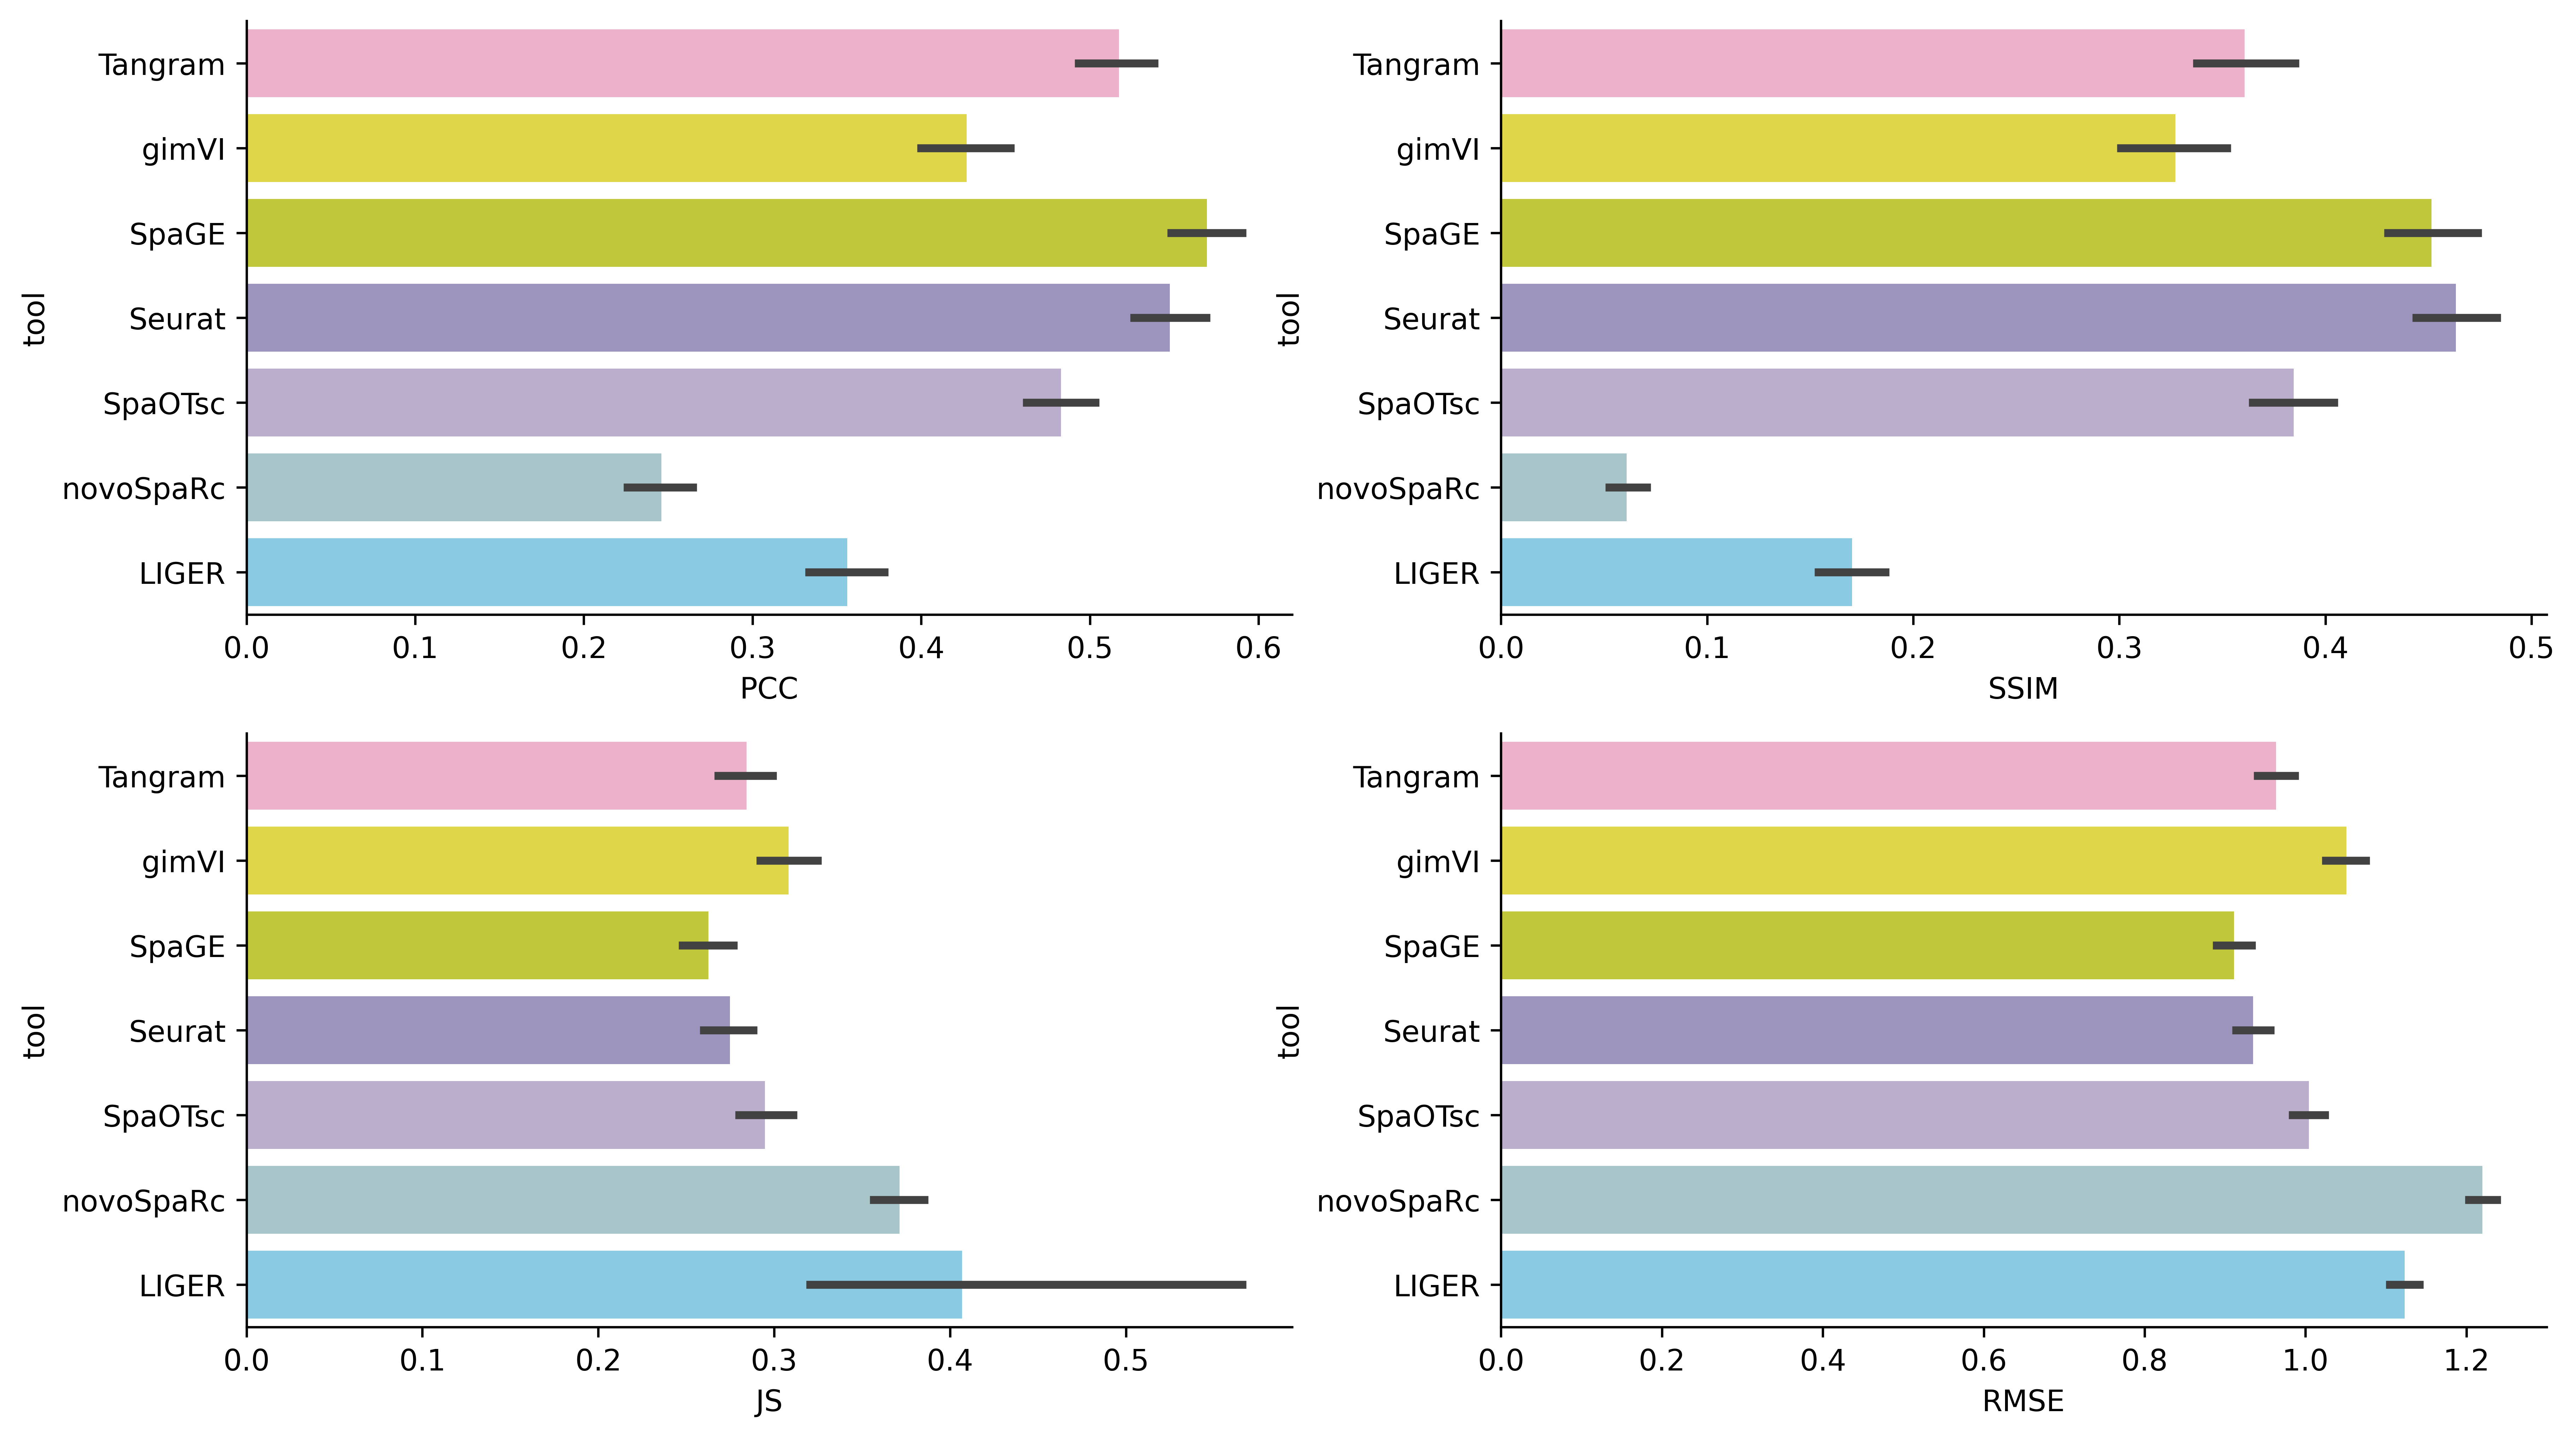

In [30]:
import seaborn as sns

PATH = "./XeniumResults/"
metric = ["PCC", "SSIM", "JS", "RMSE"]
Data = "Xenium"
Tools = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER']
outdir = "./XeniumResults/"
if not os.path.exists(outdir):
    os.system("mkdir " + outdir)
plot_boxplot(PATH, Data, metric, Tools, outdir)

# Calculated Accuracy score for every datasets of each methods

In [ ]:
# This script is used for rank get the rank score for each method


def get_score(Result):
    Result = Result.fillna(0)
    tools_num = Result.shape[0]
    Tools_score = []
    methods = list(Result.index)
    score_col = []
    list_up = list(range(1, Result.shape[1] + 1))
    list_down = list(range(Result.shape[1], 0, -1))

    for method in methods:
        if method == "PCC" or method == "SSIM":
            Tools_score.append(
                pd.Series(
                    list_down,
                    index=Result.loc[method, :].sort_values(ascending=False).index,
                )
            )

        if method == "JS" or method == "RMSE":
            Tools_score.append(
                pd.Series(
                    list_up,
                    index=Result.loc[method, :].sort_values(ascending=False).index,
                )
            )
        score_col.append(method)

    score = pd.concat([m for m in Tools_score], axis=1)
    score.columns = score_col
    score = score / Result.shape[1]
    return score


def make_score(path, dataset_all, Tools, path_output):
    Tools_data = [x for x in range(len(Tools))]
    for dataset in dataset_all:
        for i in range(len(Tools)):
            File = path + "/" + dataset + "/" + Tools[i] + "_Metrics.txt"
            if os.path.isfile(File):
                Tools_data[i] = pd.read_table(
                    path + "/" + dataset + "/" + Tools[i] + "_Metrics.txt",
                    sep="\t",
                    index_col=0,
                    header=0,
                )
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]["Tool"] = Tools[i]
            else:
                Tools_data[i] = pd.DataFrame(
                    [-2, -2, 10, 10],
                    columns=["Genes"],
                    index=["PCC", "SSIM", "RMSE", "JS"],
                ).T
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]["Tool"] = Tools[i]
        Result = pd.concat([m for m in Tools_data], axis=1)
        Result.columns = Result.loc[["Tool"], :].values.flatten()
        Result.drop("Tool", axis=0, inplace=True)

        score = get_score(Result)
        score.to_csv(path_output + dataset + "_score.txt", header=1, index=1)


path = "./XeniumResults/Metrics/"
path_output = "./XeniumResults/Metrics/Accuracy_Rank/"
if not os.path.exists(path_output):
    os.mkdir(path_output)
Tools = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "SpaOTsc",
    "novoSpaRc",
]
DirFiles = os.listdir(path)
dataset_all = [x for x in DirFiles if x[:4] == "Data"]
print(len(dataset_all))
make_score(path, dataset_all, Tools, path_output)

FileNotFoundError: [Errno 2] No such file or directory: './XeniumResults/Metrics/Accuracy_Rank/'

# Accuracy for one datasets

In [ ]:
def make_plot_one_dataset(path, Data, order, palette):
    dataset = pd.read_csv(
        path + "/Accuracy_Rank/" + Data + "_score.txt", header=0, index_col=0
    )

    dataset_mer = pd.concat(
        [
            dataset.iloc[:, 0],
            dataset.iloc[:, 1],
            dataset.iloc[:, 2],
            dataset.iloc[:, 3],
        ],
        axis=0,
    )
    dataset_mer = pd.DataFrame(
        dataset_mer, index=dataset_mer.index.values, columns=[Data]
    )
    axes = sns.violinplot(
        x=Data,
        y=dataset_mer.index.values,
        data=dataset_mer,
        order=order,
        palette=palette,
        width=0.9,
    )
    axes.set_xlabel(Data, fontsize=10)
    axes.set_ylabel("", fontsize=10)
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path + "Accuracy_Rank/" + Data + "_violinplot.pdf")
    plt.show()


path = "FigureData/Figure2/Metrics/"
dataset = "Data4"
order = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "Seurat",
    "SpaOTsc",
    "novoSpaRc",
    "LIGER",
    "stPlus",
]
palette = [
    "#F5A8C7",
    "#F9EC31",
    "#D6DE23",
    "#988DC3",
    "#BBA8D1",
    "#A2CBCF",
    "#7BD1F1",
    "#79c06e",
]
make_plot_one_dataset(path, dataset, order, palette)

path = "FigureData/Figure2/Metrics/"
dataset = "Data42"
order = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "Seurat",
    "SpaOTsc",
    "novoSpaRc",
    "LIGER",
    "stPlus",
]
palette = [
    "#F5A8C7",
    "#F9EC31",
    "#D6DE23",
    "#988DC3",
    "#BBA8D1",
    "#A2CBCF",
    "#7BD1F1",
    "#79c06e",
]
make_plot_one_dataset(path, dataset, order, palette)

# Accuracy for image, seq based

In [ ]:
def make_all_score(path, dataset_all):
    score_all = pd.DataFrame()
    for dataset in dataset_all:
        a = pd.read_csv(
            path + "/Accuracy_Rank/" + dataset + "_score.txt", header=0, index_col=0
        )
        a["DataSet"] = dataset
        score_all = pd.concat([score_all, a], axis=0)
    return score_all


def plot_all(df, name, order, palette, path):
    df = df[["PCC", "SSIM", "RMSE", "JS"]]
    df_all = pd.DataFrame(
        df.sum(axis=1).values, index=df.index.values, columns=["merge"]
    )
    df_all = df_all / 4

    plt.figure(figsize=(8, 6))
    axes = sns.boxplot(
        x="merge",
        y=df_all.index.values,
        data=df_all,
        palette=palette,
        order=order,
        flierprops=dict(marker="o", markersize=3),
    )
    axes.set_xlabel(name, fontsize=10)
    axes.set_ylabel("", fontsize=10)
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path + "/Accuracy_Rank/" + name + "_boxplot.pdf")
    plt.show()


path = "FigureData/Figure2/Metrics/"
os.popen("mkdir " + path + "Accuracy_Rank")
path_output = path + "/Accuracy_Rank/"
order = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "Seurat",
    "SpaOTsc",
    "novoSpaRc",
    "LIGER",
    "stPlus",
]
Tools = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "Seurat",
    "SpaOTsc",
    "novoSpaRc",
    "LIGER",
    "stPlus",
]
palette = [
    "#F5A8C7",
    "#F9EC31",
    "#D6DE23",
    "#988DC3",
    "#BBA8D1",
    "#A2CBCF",
    "#7BD1F1",
    "#79c06e",
]

DirFiles = os.listdir(path)
DataSets = [x for x in DirFiles if x[:4] == "Data"]
image_based_dataset = [
    "Data1",
    "Data2",
    "Data3",
    "Data4",
    "Data5",
    "Data6",
    "Data7",
    "Data8",
    "Data9",
    "Data10",
    "Data11",
    "Data12",
    "Data13",
    "Data14",
    "Data15",
    "Data16",
    "Data17",
]
seq_based_dataset = [x for x in DataSets if x not in image_based_dataset]
print(len(DataSets))
print(len(seq_based_dataset))
print(len(image_based_dataset))

image_based = make_all_score(path, image_based_dataset)
image_based.to_csv(path + "/Accuracy_Rank/image_based_score.txt", header=1, index=1)

seq_based = make_all_score(path, seq_based_dataset)
seq_based.to_csv(path + "/Accuracy_Rank/seq_based_score.txt", header=1, index=1)

plot_image = pd.read_csv(
    path + "/Accuracy_Rank/image_based_score.txt", header=0, index_col=0
)
plot_image.loc[plot_image["DataSet"] == "Data8", "JS"] = 0
plot_seq = pd.read_csv(
    path + "/Accuracy_Rank/seq_based_score.txt", header=0, index_col=0
)

plot_all(plot_seq, "seq-based", order, palette, path)
plot_all(plot_image, "image-based", order, palette, path)

# Accuracy for all datasets

In [ ]:
path = "FigureData/Figure2/Metrics/"
all_based = make_all_score(path, DataSets)
all_based.to_csv(path + "/Accuracy_Rank/Score.txt", header=1, index=1)
plot_data = pd.read_csv(path + "/Accuracy_Rank/Score.txt", header=0, index_col=0)
# JS of Dataset8 is Inf for all methods, because the spatial data has been scaled.
plot_data.loc[plot_data["DataSet"] == "Data8", "JS"] = 0
plot_all(plot_data, "Accuracy Score", order, palette, path)

# Accuracy for MERFISH datasets

In [ ]:
def plot_all(df, name, order, palette, path):
    df = df[["PCC", "SSIM", "RMSE", "JS"]]
    df_all = pd.DataFrame(
        df.sum(axis=1).values, index=df.index.values, columns=["merge"]
    )
    df_all = df_all / 4

    plt.figure(figsize=(8, 6))
    axes = sns.boxplot(
        x="merge",
        y=df_all.index.values,
        data=df_all,
        palette=palette,
        order=order,
        flierprops=dict(marker="o", markersize=3),
    )
    axes = sns.swarmplot(
        x="merge",
        y=df_all.index.values,
        data=df_all,
        order=order,
        color="black",
        size=7,
    )
    axes.set_xlabel(name, fontsize=10)
    axes.set_ylabel("", fontsize=10)
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path + "/Accuracy_Rank/" + name + "_boxplot.pdf")
    plt.show()


order = [
    "Tangram",
    "gimVI",
    "SpaGE",
    "Seurat",
    "SpaOTsc",
    "novoSpaRc",
    "LIGER",
    "stPlus",
]
palette = [
    "#F5A8C7",
    "#F9EC31",
    "#D6DE23",
    "#988DC3",
    "#BBA8D1",
    "#A2CBCF",
    "#7BD1F1",
    "#79c06e",
]
path = "FigureData/Figure2/Metrics/"
MERFISHBased = ["Data6", "Data7", "Data8", "Data9"]
MERFISH_based = make_all_score(path, MERFISHBased)
MERFISH_based.to_csv(path + "/Accuracy_Rank/MERFISH_score.txt", header=1, index=1)
plot_MERFISH = pd.read_csv(
    path + "/Accuracy_Rank/MERFISH_score.txt", header=0, index_col=0
)
plot_MERFISH["Tool"] = plot_MERFISH.index
plot_MERFISH.index = plot_MERFISH["Tool"] + "_" + plot_MERFISH["DataSet"]

### Removed LIGER and gimVI's scores for Data8 because an error occurred when making predictions for Dataset 8 using these two tools.

plot_MERFISH = plot_MERFISH.drop("LIGER_Data8", axis=0)
plot_MERFISH = plot_MERFISH.drop("gimVI_Data8", axis=0)

plot_MERFISH.index = plot_MERFISH["Tool"]
plot_MERFISH = plot_MERFISH[["PCC", "SSIM", "RMSE", "JS", "DataSet"]]
plot_MERFISH.loc[plot_MERFISH["DataSet"] == "Data8", "JS"] = 0
plot_all(plot_MERFISH, "MERFISHScore", order, palette, path)